In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os, time, re, random
from scipy import stats, io
from statsmodels.stats.multitest import multipletests

import cobra
from cobra import Model, Reaction, Metabolite, flux_analysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setup
pal4 = sns.color_palette("mako",4)
pal3 = sns.color_palette("mako",3)
pal2 = [sns.color_palette("mako",4)[3],sns.color_palette("mako",4)[0]]
pal22 = [sns.color_palette("mako",4)[0],sns.color_palette("mako",4)[3]]

folder = '../data/'

# functions
def flatten(t):
    return [item for sublist in t for item in sublist]

def fix_strings_list(x):
    return [xx.strip('[').strip(']').strip("'") for xx in list(x.split(', ')) if not pd.isna(x)]

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)


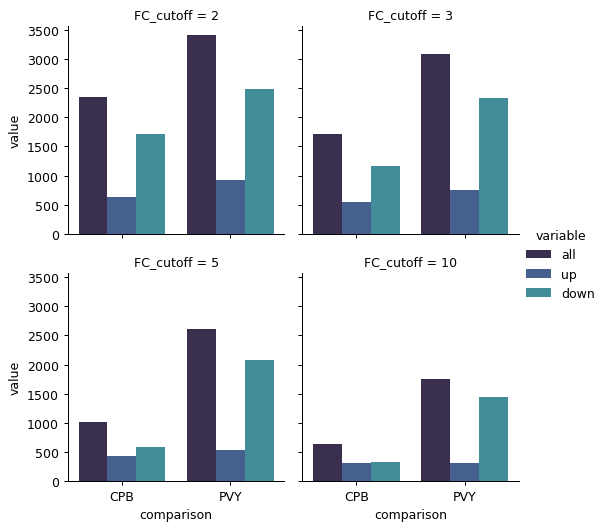

In [3]:
# dfa results

# load 
df_fxc = pd.read_csv(folder+'df_dfa_stats_log2fc.tsv', sep='\t')

# add an 'all' column
df_fxc['all'] = df_fxc.dfa_up | df_fxc.dfa_down

# supp. plot dfa at diff.FC cutoffs
mpl.rcParams['figure.dpi'] = 90
df_plot = (df_fxc
 .query('comparison.isin(["CPB_ctrl_CPB_tre","PVY_ctrl_PVY_tre"])')
 .groupby(['comparison','cut_fxc'])
 [['dfa_up','dfa_down','all']].sum()
 .reset_index()
.replace({'comparison':{'CPB_ctrl_CPB_tre':'CPB',
                       'PVY_ctrl_PVY_tre':'PVY'}})   
.melt(id_vars=['comparison','cut_fxc'],
     value_vars=['all','dfa_up','dfa_down'])
.replace({'variable':{'dfa_up':'up',
         'dfa_down':'down',
         'all':'all'}})    
          )
# add percentage all
df_plot['ratio'] = df_plot.value/7092

# plot
sns.catplot(data=df_plot.rename(columns={'cut_fxc':'FC_cutoff'}),
            kind='bar',
           x='comparison',y='value',hue='variable',col='FC_cutoff',
           palette=pal4,
            col_wrap=2, height=3
           )
plt.show()


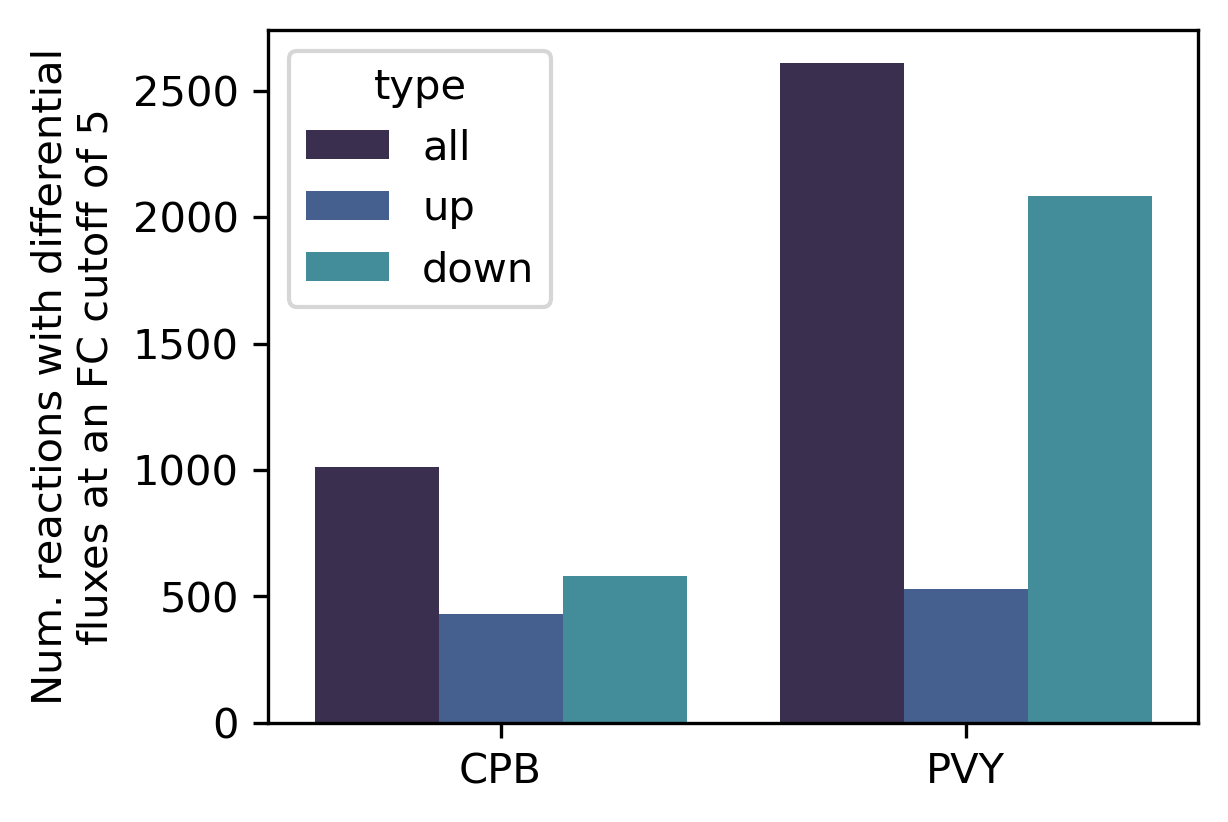

[1.45198464 1.79428904 2.57650543 2.7189441 ]
[2.6955836  2.15441176 1.34490741 1.02515723]
1.805015000258051
[2.68181818 3.13288591 3.94318182 4.72222222]
3.6200270320656225
3.9431818181818183


In [4]:
# fix6b
cut = 5
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.barplot(data=df_plot.query('cut_fxc==@cut'),
           x='comparison',y='value',hue='variable',
           palette=pal4
           )
plt.ylabel('Num. reactions with differential\nfluxes at an FC cutoff of 5')
plt.xlabel('')
plt.legend(title='type',loc='upper left')
plt.show()

# values for text
tmp = df_plot.query('variable=="all"')
print(tmp.query('comparison=="PVY"').value.values/tmp.query('comparison=="CPB"').value.values)
# CPB
tmp = df_plot.query('comparison=="CPB"') #.query('variable=="up"')
print(tmp.query('variable=="down"').value.values/tmp.query('variable=="up"').value.values)
print(np.mean(tmp.query('variable=="down"').value.values/tmp.query('variable=="up"').value.values))
# PVY
tmp = df_plot.query('comparison=="PVY"') #.query('variable=="up"')
print(tmp.query('variable=="down"').value.values/tmp.query('variable=="up"').value.values)
print(np.mean(tmp.query('variable=="down"').value.values/tmp.query('variable=="up"').value.values))

print(df_plot.iloc[22].ratio/df_plot.iloc[14].ratio)


In [5]:
# flux decrease treated vs control
df_plot = (df_fxc
 .query('comparison.isin(["CPB_ctrl_CPB_tre"])')
 .query('all==True')
 [['CPB_ctrl','CPB_tre','cut_fxc']]
 .rename(columns={'CPB_ctrl':'control',
                 'CPB_tre':'treated',
                 })
 .reset_index(drop=True)
          )
df_plot['exp'] = 'CPB'

tmp= (df_fxc
 .query('comparison.isin(["PVY_ctrl_PVY_tre"])')
 .query('all==True')
 [['PVY_ctrl','PVY_tre','cut_fxc']]
 .rename(columns={'PVY_ctrl':'control',
                 'PVY_tre':'treated',
                 })
 .reset_index(drop=True)
          )
tmp['exp'] = 'PVY'

df_plot = (pd.concat([df_plot,tmp])
           .melt(id_vars=['exp','cut_fxc'],value_vars=['control','treated'])
            )

tmp = df_plot.groupby(['variable']).value.median().reset_index()
print(tmp.iloc[1].value/tmp.iloc[0].value)


0.09879857803708063


(106,)
(198,)
(200, 12)
(198, 4)
(200, 18)


Text(0.5, 0, 'Avg. log2 fold-changes between\ntreatment and control flux samples')

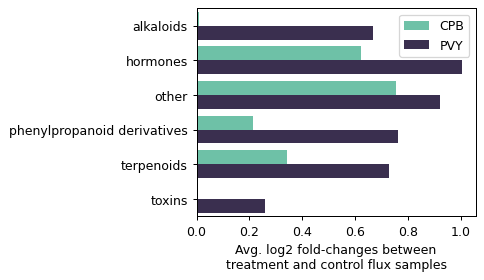

In [6]:
# supplement, dfa across secondary met. classes

# load data
df_test = pd.read_csv(folder+'2nd_met_annotations_table-15_4_25.tsv', sep='\t')
df_test['products'] = df_test['products'].apply(fix_strings_list)
df_test['product_ids'] = df_test['product_ids'].apply(fix_strings_list)
df_test['last_rxns'] = df_test['last_rxns'].apply(fix_strings_list)

df_last = (df_test
           .query('type=="2nd"')
           .explode('last_rxns')
           .query('last_rxns!="nan"')
          )
print(df_last.biocyc_pwy.unique().shape)
print(df_last.last_rxns.unique().shape)
print(df_last.shape)

# sampling medians
df_mat = (pd.read_csv(folder+'sampling_medians_9_5_2025.csv')
          .query('Var1.isin(@df_last.last_rxns)')
          .set_index('Var1')
         )
print(df_mat.shape)
df_mat

# log ratios
eps = 1e-9 # avod div-by-0
df_mat['PVY_log2fc'] = np.log2((df_mat['PVY_tre'])/(df_mat['PVY_ctrl']+eps)+1)
df_mat['CPB_log2fc'] = np.log2((df_mat['CPB_tre'])/(df_mat['CPB_ctrl']+eps)+1)
df_last = df_last.merge(df_mat,left_on='last_rxns',right_index=True,how='left')
print(df_last.shape)

# plot 
df_plot = (df_last
 .groupby(['class'])
 [['CPB_log2fc','PVY_log2fc']]
 .mean()
  .rename(columns={'CPB_log2fc':'CPB','PVY_log2fc':'PVY'})
 .reset_index()
 .melt(id_vars=['class'],value_vars=['CPB','PVY'])
)
df_plot

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))
sns.barplot(data=df_plot,
           y='class',x='value',hue='variable',
           palette=pal2
           )
plt.legend(title='')
plt.ylabel('')
plt.xlabel('Avg. log2 fold-changes between\ntreatment and control flux samples')


In [7]:
# text value
print(df_last
 .query('type=="2nd"')
 [['CPB_log2fc','PVY_log2fc']]
 .mean()
 .apply(lambda x: 2**x)
 .mean()
)

# supp. table
(df_last
 .groupby(['class','subclass'])
 [['CPB_log2fc','PVY_log2fc']]
 .mean()
 .round(3)
)

1.5401320220884345


CPB_log2fc  PVY_log2fc
class                       subclass                                   
alkaloids                   alkaloids                 0.008       0.666
hormones                    ABA                       0.404       0.282
                            Auxins                    0.000       1.185
                            Brassinosteroids          0.000       1.146
                            Cytokinins                0.544       0.899
                            Eth                       1.102       2.863
                            Gibberellins              0.135       0.757
                            JA                        2.392       0.360
                            SA                        0.390       2.022
other                       FA derivatives            1.533       0.346
                            nitrogen-containing       0.331       0.631
                            sugar alcohols            0.572       1.185
phenylpropanoid derivatives cinnamates                0.604       0.486
                            coumarins                 0.000       1.255
                            flavonoids                0.032       0.448
                            lignan                    0.358       0.824
                            lignin                    4.389       6.720
                            other                     0.511       1.064
                            phen. prec.               0.124       1.581
terpenoids                  diterpenoid               1.641       0.044
                            monoterpenoid             0.033       0.709
                            sesquiterpenoid           0.000       0.767
                            tetraterpenoid            0.714       1.666
                            triterpenoid              0.677       0.113
toxins                      phytoalexins              0.000       0.259

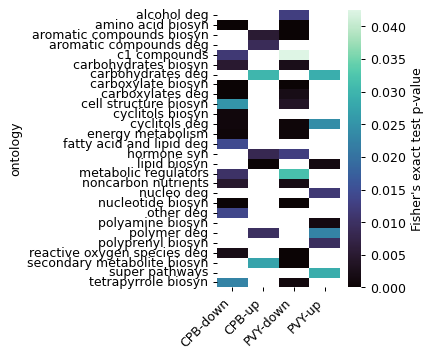

comparison                            CPB                     PVY          
direction                            down        up          down        up
ontology                                                                   
alcohol deg                           NaN       NaN  1.250407e-02       NaN
amino acid biosyn            1.161616e-12       NaN  1.965923e-10       NaN
aromatic compounds biosyn             NaN  0.005208  1.965923e-10       NaN
aromatic compounds deg                NaN  0.008828           NaN       NaN
c1 compounds                 1.148253e-02       NaN  4.248684e-02       NaN
carbohydrates biosyn         4.904728e-03       NaN  2.486887e-03       NaN
carbohydrates deg                     NaN  0.030178           NaN  0.028914
carboxylate biosyn           3.380595e-08       NaN  3.569716e-07       NaN
carboxylates deg             1.616523e-04       NaN  2.002203e-03       NaN
cell structure biosyn        2.508009e-02       NaN  3.793041e-03       NaN
cyclitols biosyn             8.945904e-04       NaN           NaN       NaN
cyclitols deg                9.234783e-04       NaN  6.225572e-04  0.023954
energy metabolism            6.178671e-04       NaN  6.291109e-04       NaN
fatty acid and lipid deg     1.428885e-02       NaN           NaN       NaN
hormone syn                           NaN  0.008200  1.250407e-02       NaN
lipid biosyn                          NaN  0.000019           NaN  0.001432
metabolic regulators         1.013083e-02       NaN  3.153680e-02       NaN
noncarbon nutrients          4.593351e-03       NaN  1.831128e-03       NaN
nucleo deg                            NaN       NaN           NaN  0.011477
nucleotide biosyn            2.329463e-07       NaN  3.525842e-07       NaN
other deg                    1.362303e-02       NaN           NaN       NaN
polyamine biosyn                      NaN       NaN           NaN  0.001432
polymer deg                           NaN  0.009754           NaN  0.022419
polyprenyl biosyn                     NaN       NaN           NaN  0.009480
reactive oxygen species deg  2.042483e-03       NaN  1.193093e-04       NaN
secondary metabolite biosyn           NaN  0.027374  4.986201e-15       NaN
super pathways                        NaN       NaN           NaN  0.028828
tetrapyrrole biosyn          2.252655e-02       NaN  1.059789e-03       NaN

In [8]:
# enrichement across ontologies

# load
df_ont = pd.read_csv(folder+'export_df_enrich2_sorted_max_fc.tsv',sep='\t')
        
df_plot = (df_ont.set_index(['ontology','comparison','direction'])
        [['fish_pval_corr','cut_fxc']]
         .sort_index(level=[1,2])
         .unstack(level=[1,2])
         .sort_index(level=0,ascending=True)
          )

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(2.2,4))
sns.heatmap(df_plot['fish_pval_corr'],
            cmap='mako',
            cbar_kws={'label':"Fisher's exact test p-value"},
           xticklabels=True, yticklabels=True)
plt.xlabel('')
plt.xticks(rotation=45,ha='right')
plt.show()

# supp. table
df_plot['fish_pval_corr']


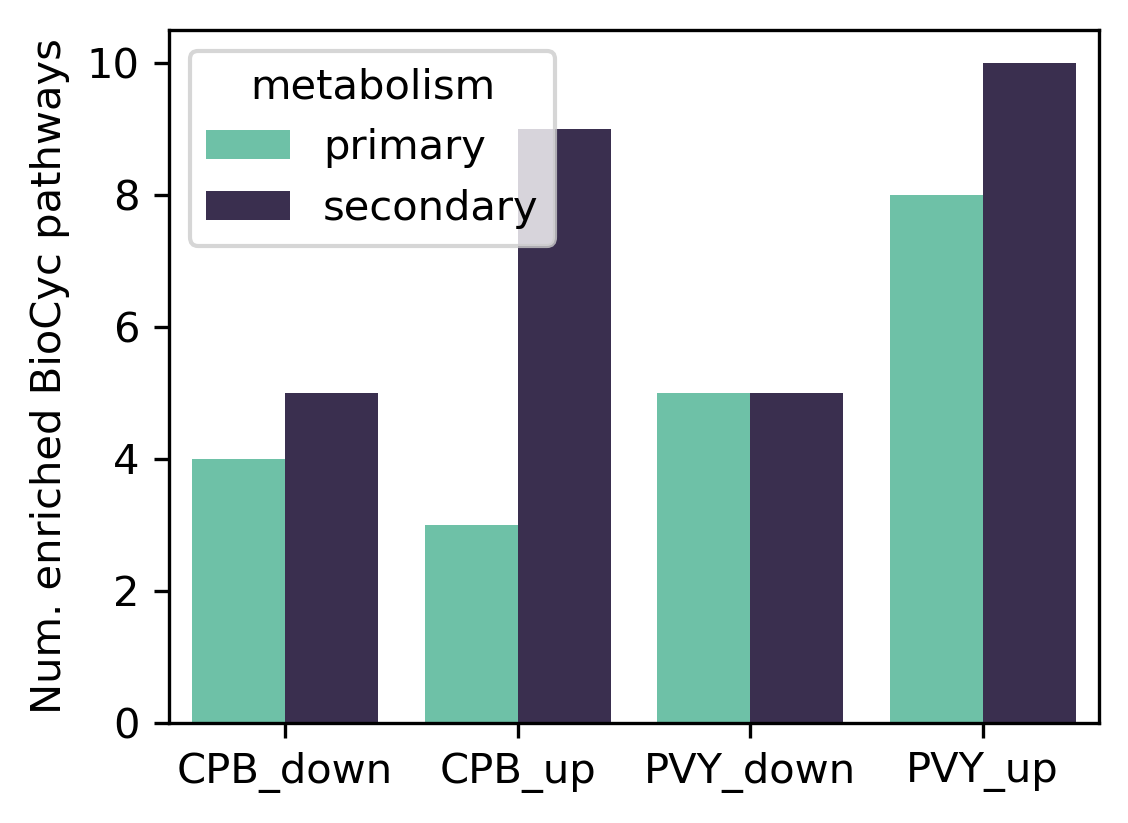

In [9]:
# fig6c

# load
df_pws = pd.read_csv(folder+'export_df_enrich3_sorted_max_fc.tsv',sep='\t')
df_pws['combined'] = df_pws.comparison+'_'+df_pws.direction

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.barplot(data=df_pws
            .groupby(['comparison','direction','combined','type2'])
            .fish_pval_corr
            .count()
            .rename('count')
            .reset_index(),
           x='combined',y='count',hue='type2',
            palette=pal2
           )
plt.ylabel('Num. enriched BioCyc pathways')
plt.xlabel('')
plt.legend(title='metabolism',loc='upper left')
plt.show()


In [10]:
# values for text
# count cpb and pvy
print(df_pws.reset_index().groupby('comparison').pws.count()) 
print(df_pws.reset_index().groupby(['comparison','type']).pws.count()) 

# increases in figure
tmp = (df_pws
            .groupby(['comparison','direction','combined','type2'])
            .fish_pval_corr
            .count()
            .rename('count')
            .reset_index()
)
tmp
print(tmp.iloc[2]['count']/tmp.iloc[0]['count'])
print(tmp.iloc[3]['count']/tmp.iloc[1]['count'])
print(tmp.iloc[6]['count']/tmp.iloc[4]['count'])
print(tmp.iloc[7]['count']/tmp.iloc[5]['count'])


comparison
CPB    21
PVY    28
Name: pws, dtype: int64
comparison  type      
CPB         2nd           14
            precursors     3
            primary        4
PVY         2nd           15
            precursors     5
            primary        8
Name: pws, dtype: int64
0.75
1.8
1.6
2.0


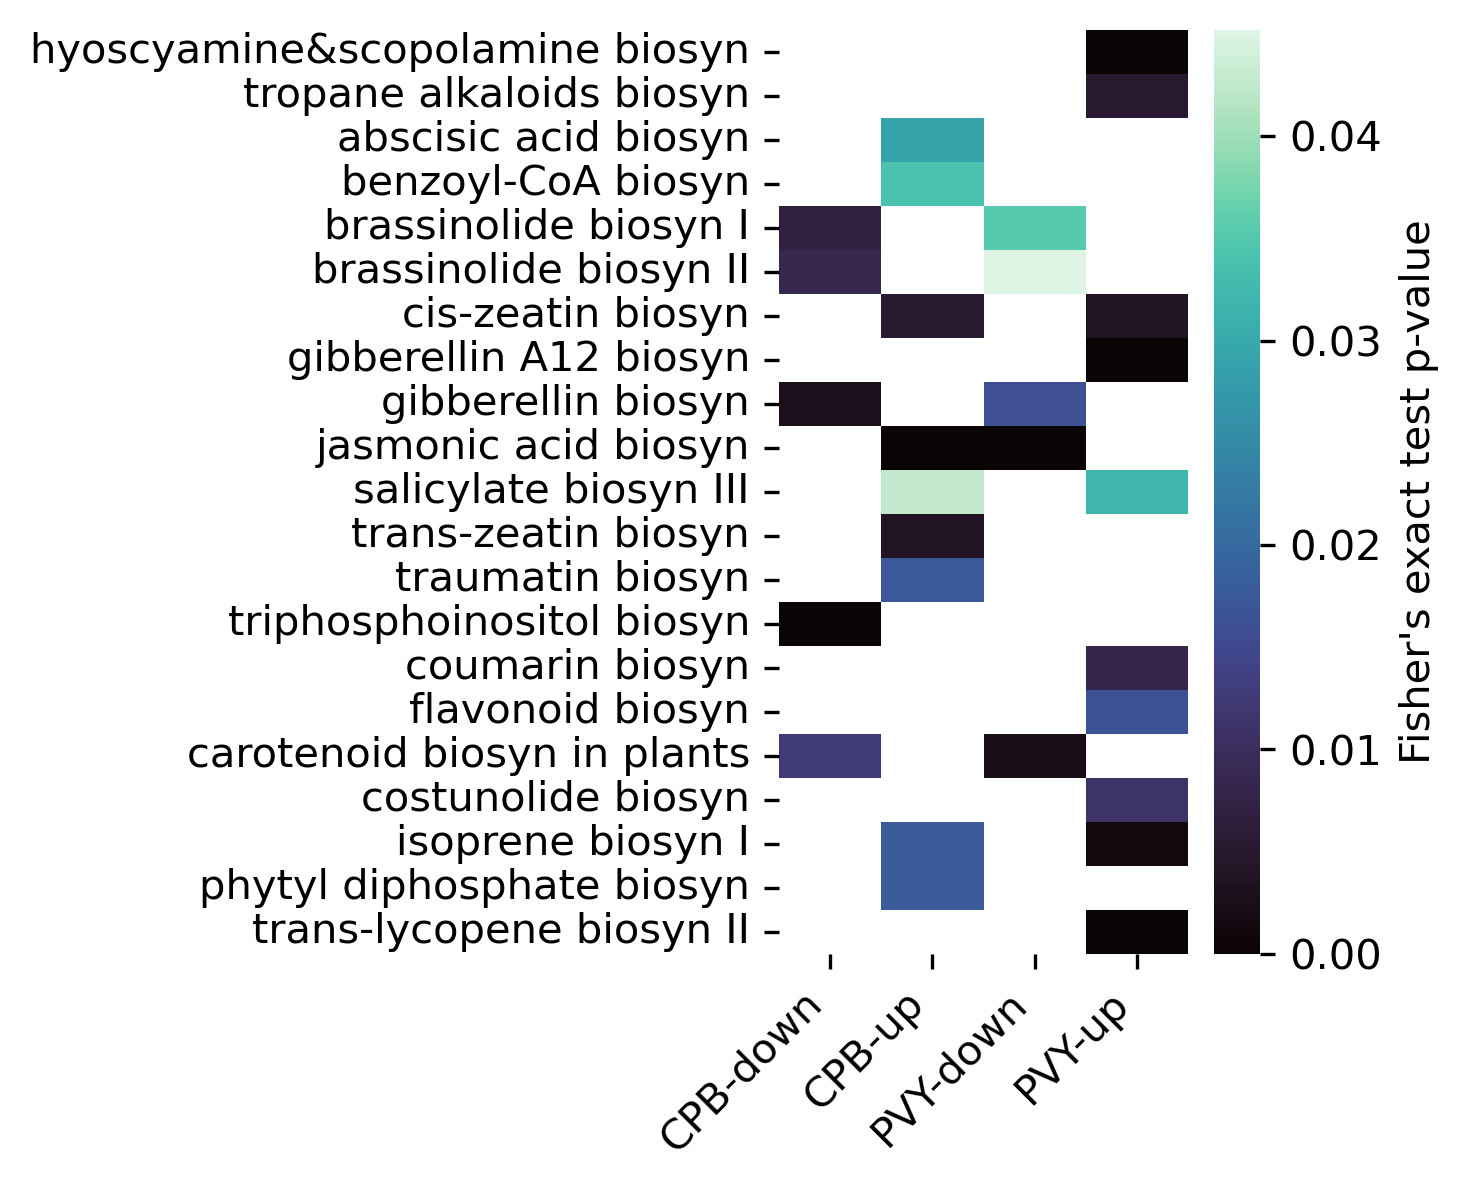

In [11]:
# Fig 6D,E

# plot secondary
df_pws['plt_ind2'] = df_pws['class2']+' | '+df_pws['plt_ind']
tmp = (df_pws
     .query('type2=="secondary"')
     .set_index(['class','plt_ind','comparison','direction'])
     .fish_pval_corr
     .unstack(level=[2,3])
     .sort_index(level=[0])
     .droplevel(0)
     .sort_index(level=[0],axis=1)
)

plt.figure(figsize=(2.2,4))
sns.heatmap(tmp,
            cmap='mako',
            cbar_kws={'label':"Fisher's exact test p-value"},
            xticklabels=True, yticklabels=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,ha='right')
plt.show()


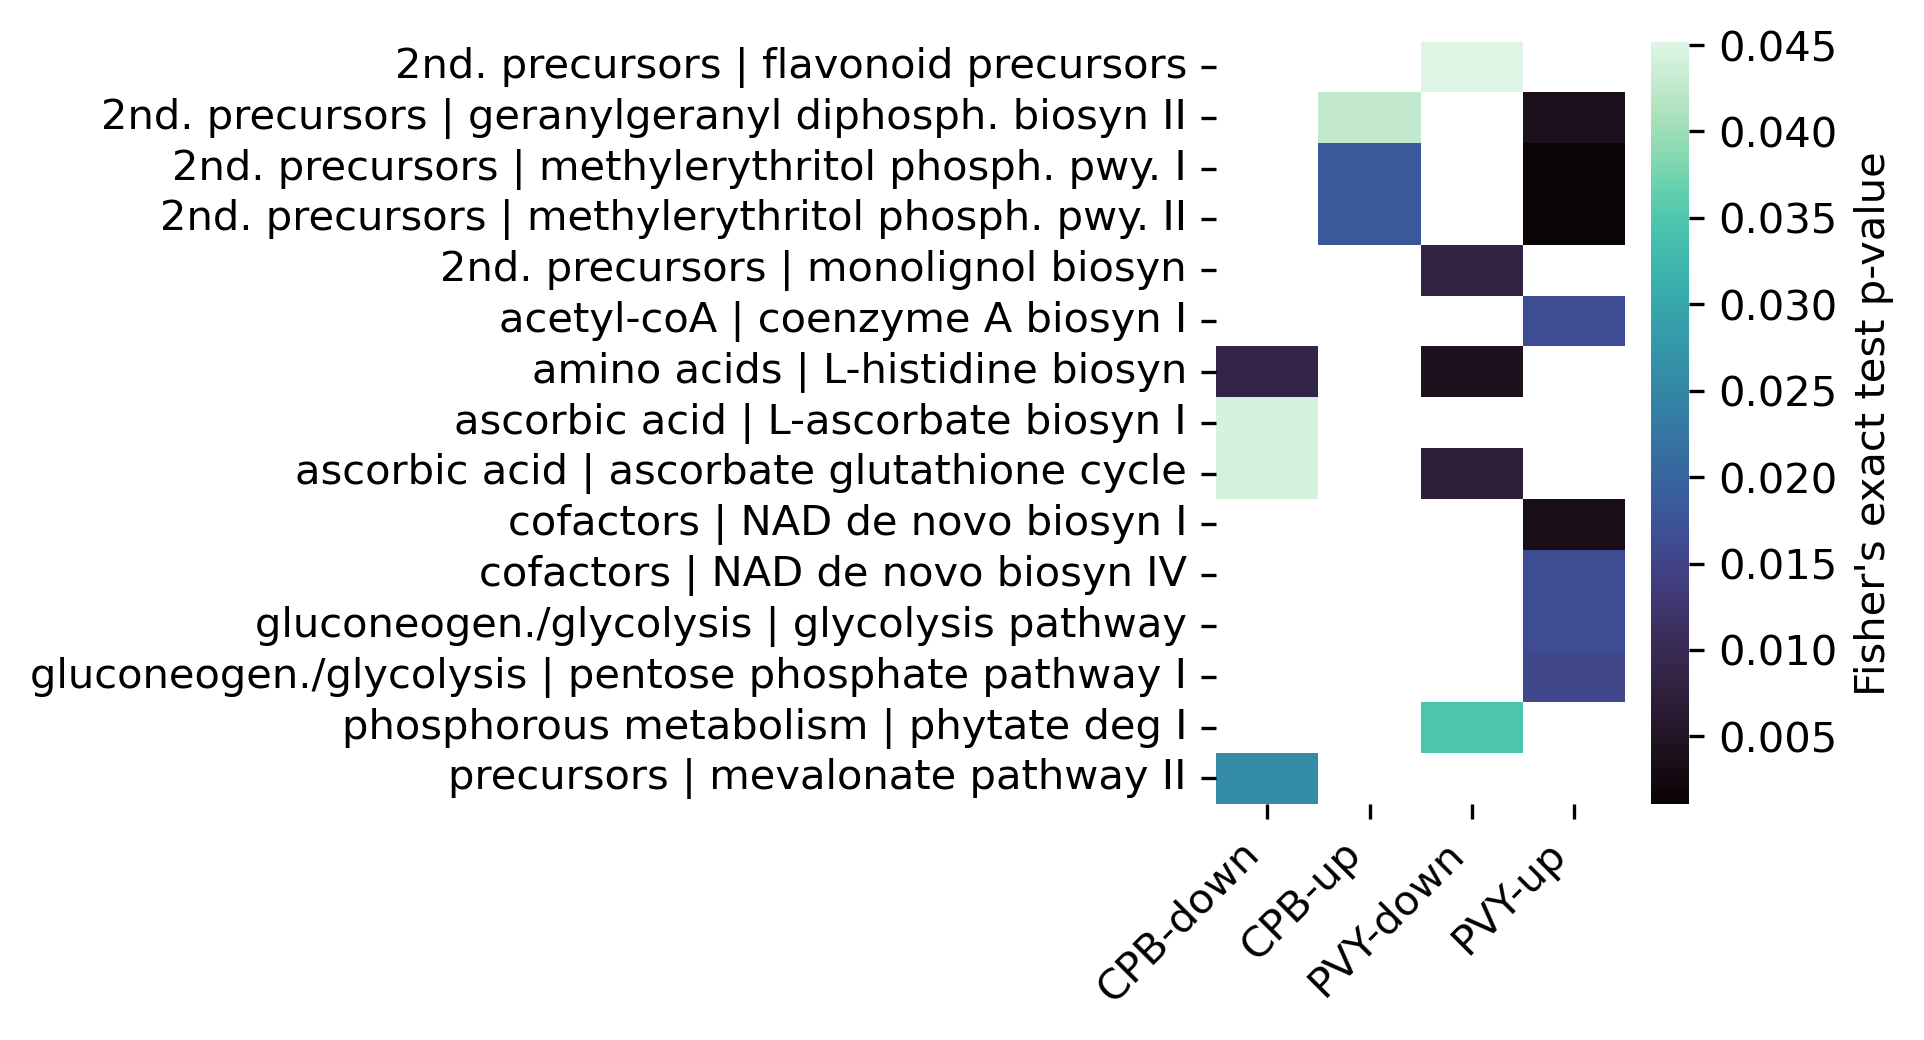

In [12]:
# plot primary
tmp = (df_pws
     [df_pws['type2']=="primary"] 
     .set_index(['class','plt_ind2','comparison','direction'])
     .fish_pval_corr
     .unstack(level=[2,3])
     .sort_index(level=[0])
     .droplevel(0)
     .sort_index(level=[0],axis=1)
)

plt.figure(figsize=(2.2,3.3))
sns.heatmap(tmp,
            cmap='mako',
            cbar_kws={'label':"Fisher's exact test p-value"},
            xticklabels=True, yticklabels=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,ha='right')
plt.show()


In [13]:
# supplementary table
(df_pws.set_index(['class','pws','plt_ind','comparison','direction',])
  [['fish_pval_corr']]
 .sort_index(level=[3,4])
 .unstack(level=[3,4])
 .sort_index(level=0,ascending=False)
  )


fish_pval_corr  \
comparison                                                                                     CPB   
direction                                                                                     down   
class                       pws                  plt_ind                                             
terpenoids                  PWY-6540             costunolide biosyn                            NaN   
                            PWY-6475             trans-lycopene biosyn II                      NaN   
                            PWY-6270             isoprene biosyn I                             NaN   
                            PWY-5063             phytyl diphosphate biosyn                     NaN   
                            CAROTENOID-PWY       carotenoid biosyn in plants              0.012527   
primary                     PYRIDNUCSYN-PWY      NAD de novo biosyn I                          NaN   
                            PWY-882              L-ascorbate biosyn I                     0.044411   
                            PWY-8277             NAD de novo biosyn IV                         NaN   
                            PWY-6174             mevalonate pathway II                    0.025803   
                            PWY-4702             phytate deg I                                 NaN   
                            PWY-2261             ascorbate glutathione cycle              0.044241   
                            OXIDATIVEPENT-PWY    pentose phosphate pathway I                   NaN   
                            HISTSYN-PWY          L-histidine biosyn                       0.008648   
                            GLYCOLYSIS-E-D       glycolysis pathway                            NaN   
                            COA-PWY              coenzyme A biosyn I                           NaN   
precursors                  flavonoid_precursors flavonoid precursors                          NaN   
                            PWY-7560             methylerythritol phosph. pwy. II              NaN   
                            PWY-5121             geranylgeranyl diphosph. biosyn II            NaN   
                            PWY-361              monolignol biosyn                             NaN   
                            NONMEVIPP-PWY        methylerythritol phosph. pwy. I               NaN   
phenylpropanoid derivatives PWY-6787             flavonoid biosyn                              NaN   
                            PWY-5176             coumarin biosyn                               NaN   
other                       PWY-6351             triphosphoinositol biosyn                0.000046   
                            PWY-5410             traumatin biosyn                              NaN   
hormones                    PWY-981              salicylate biosyn III                         NaN   
                            PWY-735              jasmonic acid biosyn                          NaN   
                            PWY-699              brassinolide biosyn I                    0.006897   
                            PWY-695              abscisic acid biosyn                          NaN   
                            PWY-6458             benzoyl-CoA biosyn                            NaN   
                            PWY-5053             gibberellin A12 biosyn                        NaN   
                            PWY-5052             gibberellin biosyn                       0.002998   
                            PWY-2781             cis-zeatin biosyn                             NaN   
                            PWY-2681             trans-zeatin biosyn                           NaN   
                            PWY-2582             brassinolide biosyn II                   0.008648   
alkaloids                   PWY-7341             hyoscyamine&scopolamine biosyn                NaN   
                            PWY-5317             tropane alkaloids biosyn                      NaN   

   

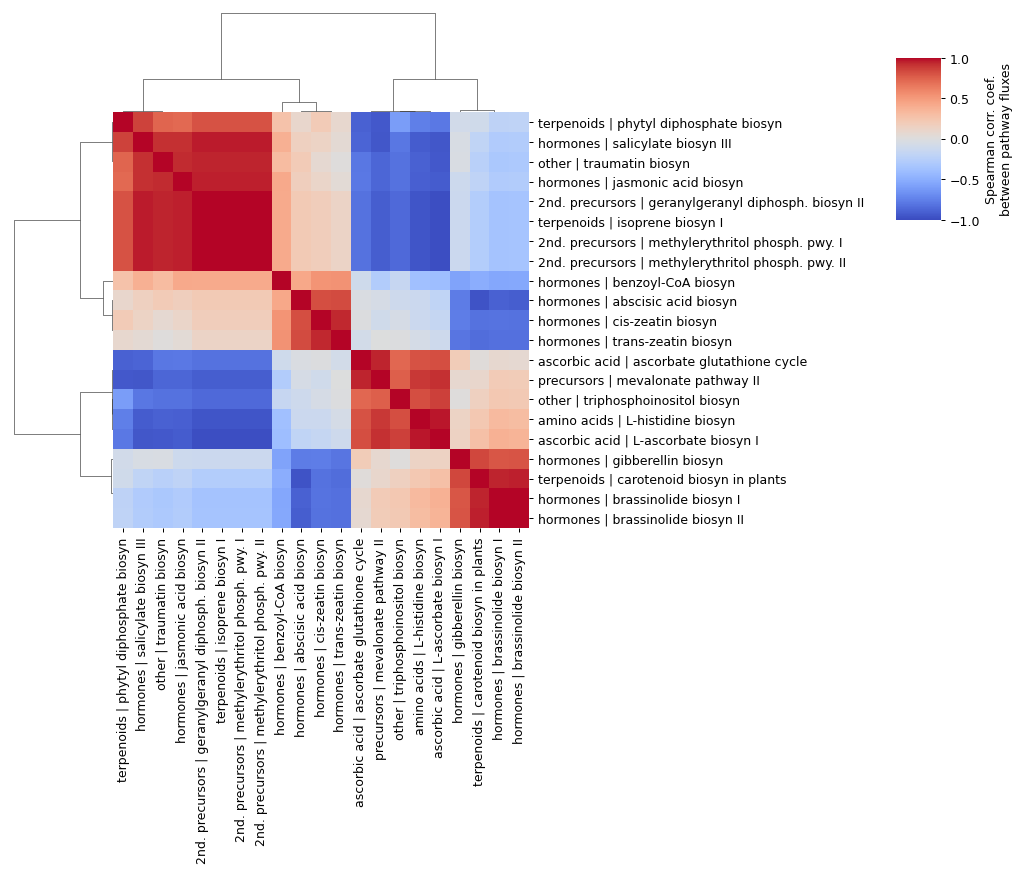

In [14]:
# correlations
# supplement: all vs all

# cpb
corr_cpb = pd.read_csv(folder+'corr_cpb_24_5_25.tsv',sep='\t')

mpl.rcParams['figure.dpi'] = 90
g = sns.clustermap(data=corr_cpb
            .set_index(['plt_ind2_x','plt_ind2_y'])['r'].unstack().transpose()
                   .rename(index={'plt_ind2_x':''})
                   .rename(columns={'plt_ind2_y':''}),
            metric='cosine',
            cmap='coolwarm',
            cbar_kws={'label': 'Spearman corr. coef.\nbetween pathway fluxes'},
            vmin=-1, vmax=1, # limits for cbar
               figsize=(10,10)
           )
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1,0.75, _w, _h])
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
#plt.xticks(rotation=45,ha='right')
plt.show()


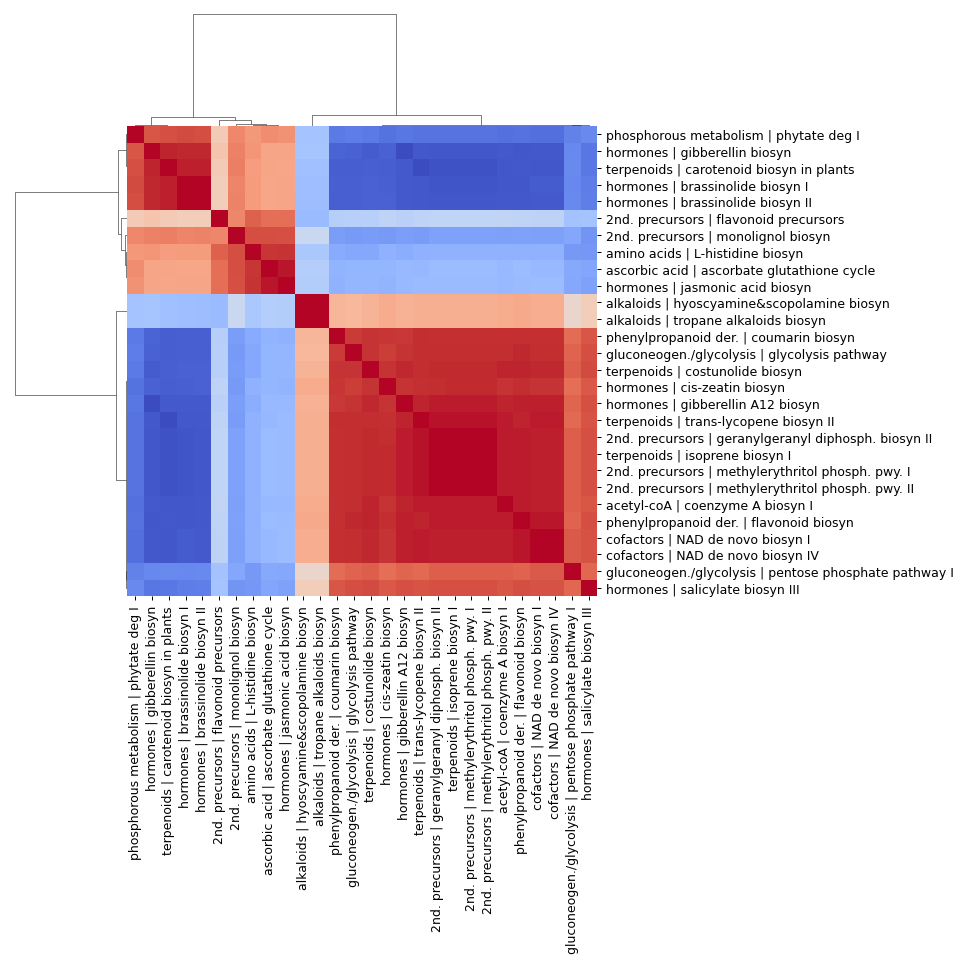

In [15]:
# pvy
corr_pvy = pd.read_csv(folder+'corr_pvy_24_5_25.tsv',sep='\t')

g = sns.clustermap(data=corr_pvy
            .set_index(['plt_ind2_x','plt_ind2_y'])['r'].unstack().transpose(),
            metric='cosine',
            cmap='coolwarm',
            cbar_kws={'label': 'Spearman corr. coef.\nbetween pathway fluxes'},
            vmin=-1, vmax=1, 
               figsize=(11,11)
           )
g.cax.set_visible(False)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
#plt.xticks(rotation=45,ha='right')
plt.show()


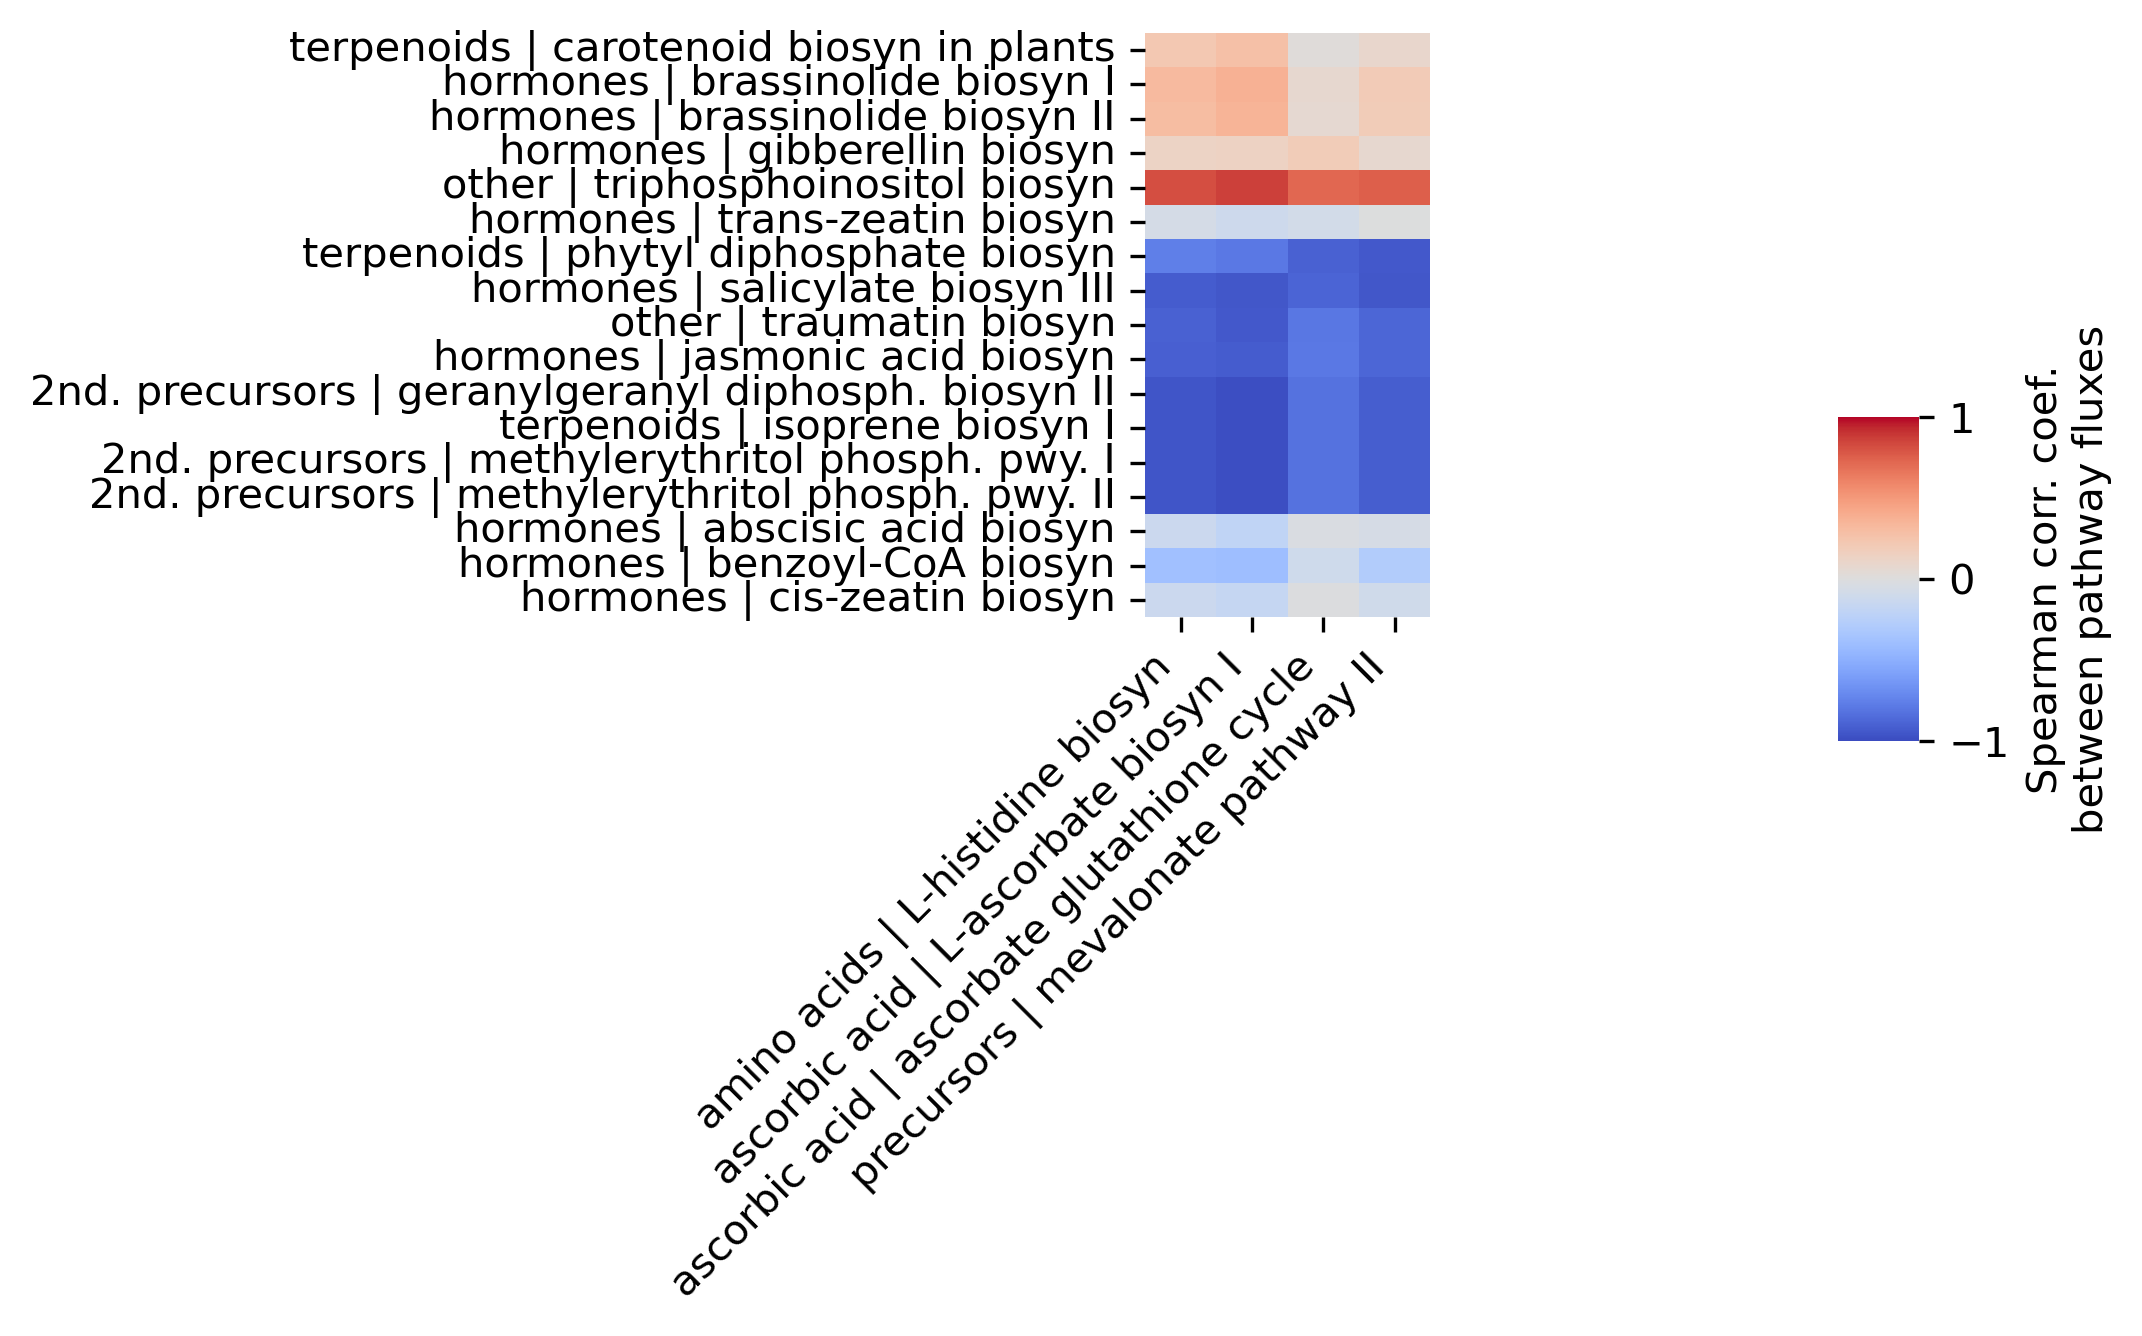

In [16]:
# Fig 6F,G
# plot sec vs prim

# cpb
mpl.rcParams['figure.dpi'] = 300
g = sns.clustermap(data=corr_cpb
            .query('class_x=="primary"')
            .query('class_y!="primary"')
            .set_index(['plt_ind2_x','plt_ind2_y'])['r'].unstack().transpose(),
            metric='cosine',
            cmap='coolwarm',
            cbar_kws={'label': 'Spearman corr. coef.\nbetween pathway fluxes'},
            vmin=-1, vmax=1, # limits for cbar
               figsize=(5.4,6),
           )
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([0.5,0.5, _w, _h])
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
#g.ax_heatmap.YAxisLocation = 'left'
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(),rotation=45,ha='right')
plt.show()


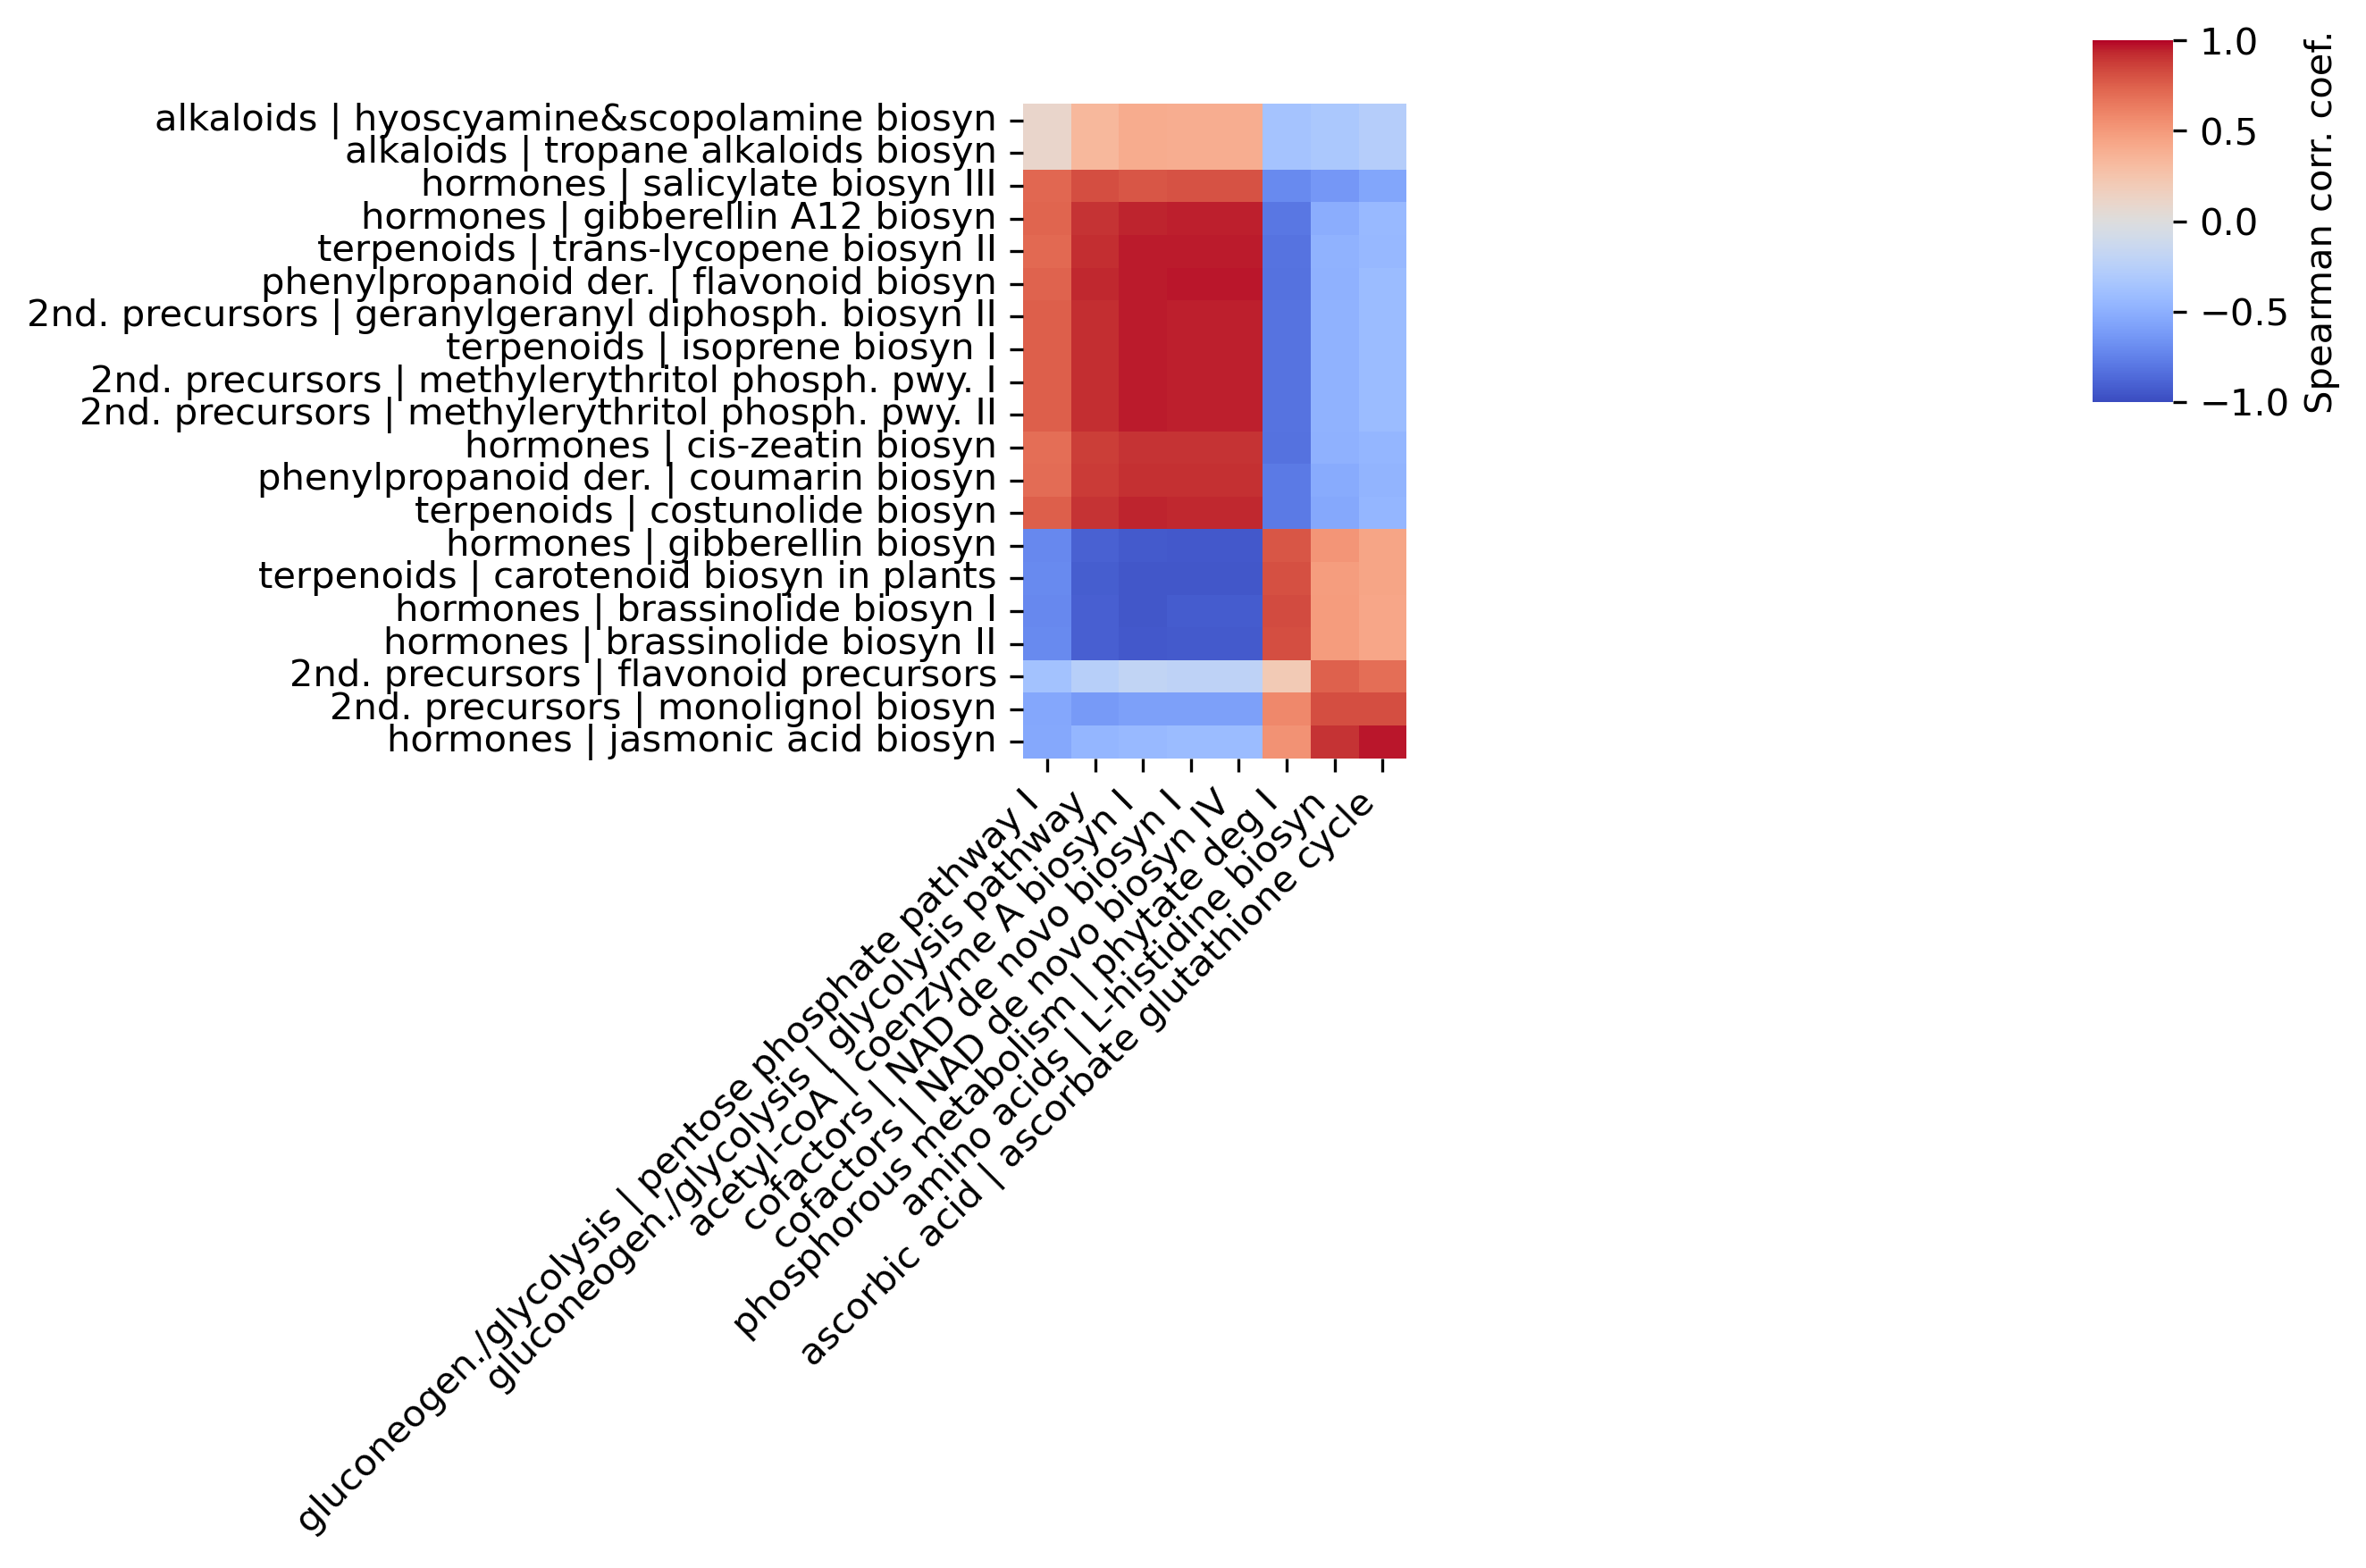

In [17]:
# pvy
g = sns.clustermap(data=corr_pvy
            .query('class_x=="primary"')
            .query('class_y!="primary"')
            .set_index(['plt_ind2_x','plt_ind2_y'])['r'].unstack().transpose(),
            metric='cosine',
            cmap='coolwarm',
            cbar_kws={'label': 'Spearman corr. coef.'},
            vmin=-1, vmax=1, # limits for cbar
               #figsize=(7.5,7),
                   figsize=(6,7.5),
            #dendrogram_ratio=0.1
           )
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([0.75,0.75, _w, _h])
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(),rotation=45,ha='right')
plt.show()


In [18]:
# stats
# Correlation level threshold for significance
tmp = corr_pvy.set_index(['plt_ind2_x','plt_ind2_y'])[['r','p']]
print(tmp.query('p<0.05').r.abs().min())

# significant correlations found between all pathways
# min 2nd row across prim
# cpb
tmpr = (corr_cpb.query('class_x=="primary"')
            .query('class_y!="primary"')
            .set_index(['plt_ind2_x','plt_ind2_y'])['r']
             .unstack() #.transpose()
            .abs()
            .max()
          .min()
       )
print(tmpr,(corr_cpb.query('class_x=="primary"')
         .query('class_y!="primary"')
         .iloc[np.where(corr_cpb.query('class_x=="primary"')
                        .query('class_y!="primary"').r==-tmpr)[0][0]].p
        )
     )
# pvy
tmpr = (corr_pvy.query('class_x=="primary"')
            .query('class_y!="primary"')
            .set_index(['plt_ind2_x','plt_ind2_y'])['r']
             .unstack() #.transpose()
            .abs()
            .max()
          .min()
       )
print(tmpr,(corr_pvy.query('class_x=="primary"')
         .query('class_y!="primary"')
         .iloc[np.where(corr_pvy.query('class_x=="primary"')
                        .query('class_y!="primary"').r==tmpr)[0][0]].p
        )
     )


0.0983222423222423
0.1128142248142248 0.0003509600271359
0.3992601778863655 1.4676159977324302e-39


In [19]:
# supp. table CPB
corr_cpb['r_abs'] = corr_cpb['r'].abs()
(corr_cpb
 .query('class_x=="primary"')
 .query('class_y!="primary"')
 .query('r_abs>0.5')
 .rename(columns={'plt_ind2_x':'primary','plt_ind2_y':'secondary'})
 .set_index(['primary','secondary'])['r']
)

primary                                      secondary                                           
amino acids | L-histidine biosyn             2nd. precursors | methylerythritol phosph. pwy. I      -0.957188
                                             terpenoids | phytyl diphosphate biosyn                 -0.764086
                                             2nd. precursors | geranylgeranyl diphosph. biosyn II   -0.957188
                                             other | traumatin biosyn                               -0.900426
                                             terpenoids | isoprene biosyn I                         -0.957188
                                             other | triphosphoinositol biosyn                       0.813994
                                             hormones | jasmonic acid biosyn                        -0.908198
                                             2nd. precursors | methylerythritol phosph. pwy. II     -0.957188
                      

In [20]:
# supp. table PVY
corr_pvy['r_abs'] = corr_pvy['r'].abs()
(corr_pvy
 .query('class_x=="primary"')
 .query('class_y!="primary"')
 .query('r_abs>0.5')
 .rename(columns={'plt_ind2_x':'primary','plt_ind2_y':'secondary'})
 .replace({'primary':{'gluconeogen./glycolysis | pentose phosphate pathway I':'gluconeogen./glycolysis | pentose phosphate p. I'}})
 [['primary','secondary','r']]
 .head(60)
)

,primary,secondary,r
28,acetyl-coA | coenzyme A biosyn I,terpenoids | carotenoid biosyn in plants,-0.952554
32,acetyl-coA | coenzyme A biosyn I,2nd. precursors | methylerythritol phosph. pwy. I,0.956022
35,acetyl-coA | coenzyme A biosyn I,hormones | brassinolide biosyn II,-0.943666
36,acetyl-coA | coenzyme A biosyn I,hormones | cis-zeatin biosyn,0.904077
37,acetyl-coA | coenzyme A biosyn I,2nd. precursors | monolignol biosyn,-0.592532
39,acetyl-coA | coenzyme A biosyn I,hormones | gibberellin biosyn,-0.934495
40,acetyl-coA | coenzyme A biosyn I,hormones | gibberellin A12 biosyn,0.942372
41,acetyl-coA | coenzyme A biosyn I,2nd. precursors | geranylgeranyl diphosph. bio...,0.955700
42,acetyl-coA | coenzyme A biosyn I,phenylpropanoid der. | coumarin biosyn,0.909075
44,acetyl-coA | coenzyme A biosyn I,terpenoids | isoprene biosyn I,0.956022
